# Generating Simpsons Scenes from sketches using a pix2pix model

In this Notebook, we will use the [Simpsons dataset](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/) to train a pix2pix model to generate Simpsons scenes from simple drawings. 

The pix2pix allows to build generative models conditioned on spatial inputs (i.e. images)

paper:
* [pix2pix](https://arxiv.org/abs/1611.07004)

In [1]:
import scipy
import numpy as np
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2
import seaborn as sns

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

## The Data

number of images: 20933


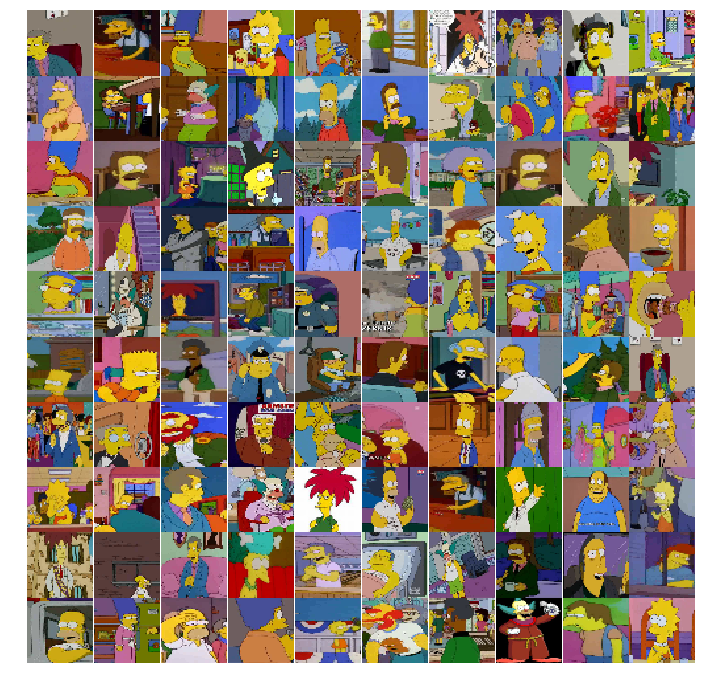

In [2]:
root = "/scratch/simpsons/simpsons_dataset" # path where the data was extracted

def getPaths(root):
    for sub_dir in os.listdir(root):
        sub_path = os.path.join(root,sub_dir)
        for file in os.listdir(sub_path):
            if 'jpg' in file:
                yield(os.path.join(sub_path,file))
def readimg(l):
    im = cv2.imread(l)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            
paths = list(getPaths(root))
print("number of images:", len(paths))

i_ = 0
plt.figure(figsize=(12, 12)) 
plt.subplots_adjust(wspace=0, hspace=0)
for l in np.random.choice(paths,100):
    im = readimg(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(10, 10, i_+1) #.set_title(l)
    plt.imshow(im); plt.axis('off')
    i_ += 1

In [3]:
#shapes = set([scipy.ndimage.imread(p).shape for p in paths])
#heights = [s[0] for s in shapes]
#widths = [s[1] for s in shapes]
#plt.title("height and widths distribution")
#sns.distplot(heights)
#sns.distplot(widths)
#plt.show()

### Resizing the data

We need to resize the data into the same format for our generative model

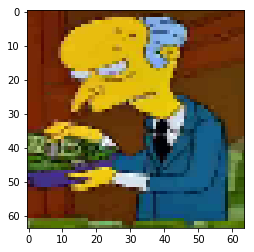

In [4]:
IMG_SIZE = 64
def resize(img):
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

plt.imshow(resize(readimg(paths[999])))

### Edge Extraction

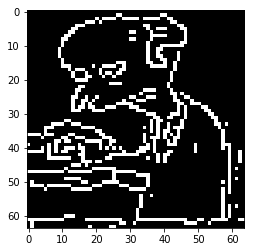

In [5]:
def edgeExtract(img):
    return cv2.Canny(img,300,300)
img = resize(readimg(paths[999]))
edges = edgeExtract(img)
plt.imshow(edges,cmap='gray')

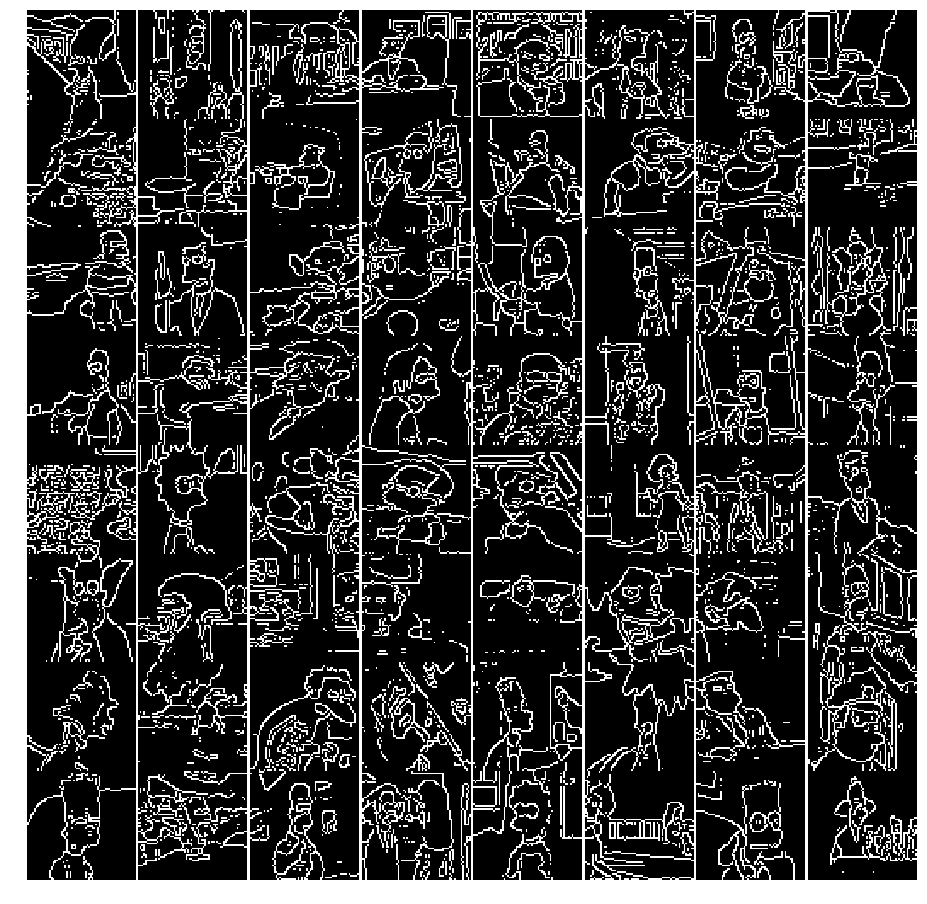

In [6]:
m = 8
i_ = 0
plt.figure(figsize=(16, 16)) 
plt.subplots_adjust(wspace=0, hspace=0)
for l in np.random.choice(paths,m**2):
    im = resize(readimg(l))
    im = edgeExtract(im)
    plt.subplot(m, m, i_+1) #.set_title(l)
    plt.imshow(im, cmap="gray"); plt.axis('off')
    i_ += 1

### Pytorch Dataset

In [10]:
import scipy
import numpy as np
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

def getPaths(root):
    for sub_dir in os.listdir(root):
        sub_path = os.path.join(root,sub_dir)
        for file in os.listdir(sub_path):
            if 'jpg' in file:
                yield(os.path.join(sub_path,file))
def readimg(l):
    im = cv2.imread(l)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def resize(img,size):
    return cv2.resize(img, (size, size)) 

def edgeExtract(img):
    edges =  cv2.Canny(img,300,300)
    #edges = cv2.dilate(edges,kernel = np.ones((5,5),np.uint8),iterations = 1)
    return edges 

class Simpsons(Dataset):
    """Simpsons dataset."""
    def __init__(self, root_dir, size, transform = None, hole_size=0, n_holes = 0):
        
        def randomHoles(x):
            r = hole_size
            for _ in range(n_holes):
                i = np.random.choice(range(x.shape[0]-r))
                j = np.random.choice(range(x.shape[1]-r))
                x[i:i+r,j:j+r] = 0
            return x
        
        self.paths = list(getPaths(root_dir))
        self.size = size
        self.img_transform = transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
               ])
        self.edge_transforms = transforms.Compose([
                   transforms.Lambda(randomHoles),
                   transforms.ToTensor(),
               ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = resize(readimg(self.paths[idx]), self.size)
        return self.img_transform(img), self.edge_transforms(edgeExtract(img)[:,:,None])

In [12]:
dataset = Simpsons(root,64)
dataset[0][0].shape,dataset[0][1].shape

(torch.Size([3, 64, 64]), torch.Size([1, 64, 64]))

In [13]:
dataset[0][0].min(), dataset[0][0].max()

(tensor(-1.), tensor(1.))

## Model

The pix2pix model uses

* a U-Net model as generative model $G$. This model takes an image $y$ (or other 2D input) as input and produces another image $x$ (or other 2D input)
* a convolutional dscriminator model $D$. This model takes both $x$ and $y$ as input and tries to guess if $x \sim p_x$ or $x \sim p_G$

The model is trained using the GAN loss function and an additional $L_1$ loss on the output of the generative model $G$. Both losses are balanced using an additional hyperparameter $lambda$ (set to 100 in the original paper), the loss is:

$L = L_{GAN} + \lambda * L_1$

Additionally, for $L_{GAN}$, we use the Wassertstein distance as loss function (WGAN) and use gradient penalty to ensure the Lipschitz property (WGAN-GP).

### Generator $G$

In [14]:
from unet import UNet

### Discriminator $D$

In [15]:
from unet import ConvolutionalEncoder, ResidualBlock

## Set Model

In [16]:
batch_size = 32
m_test = int(np.sqrt(batch_size))
m_test = m_test - 1 if m_test**2 > batch_size else m_test
lr = 6e-4
lambda_l1 = 1000 # original paper value is 100

in_channels = 1
out_channels = 3
n_features_zero = 32
group_norm = 8
n_resblocks = 1
num_dilated_convs = 4
depth = 4
kernel_size = 3
padding = 1

num_hidden_features = [n_features_zero * 2**k for k in range(depth)]

# models
try:
    del generator
except:
    0
try:
    del discriminator
except:
    0
    
# generator
generator = UNet(in_channels, 
                 out_channels, 
                 num_hidden_features,
                 n_resblocks,
                 num_dilated_convs,
                 dropout_min=0.1, 
                 dropout_max=0.3, 
                 gated=False, 
                 padding=1, 
                 kernel_size=3,
                 group_norm=group_norm)

generator = nn.Sequential(generator, nn.Tanh())

#discriminator
class Discriminator(nn.Module):
    def __init__(self, kwargs):
        super(Discriminator, self).__init__()
        self.encoder = ConvolutionalEncoder(**kwargs)
        self.convout = nn.Conv2d(kwargs['num_hidden_features'][-1],1,kernel_size=3,padding=1)

    def forward(self, input):

        output,skips = self.encoder(input)
        output = self.convout(output)
        return output
    
class Identity(nn.Module):
    def __init__(self,features):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
    
discriminator = Discriminator({'n_features_input':in_channels + out_channels,
                              'num_hidden_features':num_hidden_features,
                              'kernel_size':kernel_size,
                              'padding':padding,
                              'n_resblocks':n_resblocks,
                              'dropout_min':0.1,
                              'dropout_max':0.3, 
                              'blockObject':ResidualBlock,
                              'batchNormObject':Identity})




def weights_init(m):
    if isinstance(m, nn.Conv2d): 
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.Linear):
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)
            
#generator.apply(weights_init)
#discriminator.apply(weights_init)
            

generator = generator.to(device)
discriminator = discriminator.to(device)
# otpimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

# data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
data_loader2 = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# init training params and logger
dis = updatable_display2(['train'],["epoch","d_error","g_error", "L1"])
global_step=0
epoch =0
g_error = 0

### Training

#### WGAN-GP Gradients Penlaty

In [17]:
def calc_gradient_penalty(netD, real_data, fake_data):
    LAMBDA = 10 # recommended value from the original paper
    alpha = torch.rand(real_data.size(0), 1).requires_grad_()
    alpha = alpha[:,:,None,None]
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device) 

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

### Train Discriminator

In [18]:
def train_discriminator(optimizer, real_data, real_labels, fake_data, fake_labels):
    optimizer.zero_grad()
    # 1.1 Train on Real Data
    real_input = torch.cat([real_data,real_labels],1)
    prediction_real = discriminator(real_input).squeeze()
    # 1.2 Train on Fake Data
    fake_input = torch.cat([fake_data,fake_labels],1)
    prediction_fake = discriminator(fake_input).squeeze()
    # gradients penalty (Lipschitz condition) (WGAN-GP)
    penalty = calc_gradient_penalty(discriminator,real_input, fake_input)
    loss = prediction_fake.mean() - prediction_real.mean() + penalty
    loss.backward()
    optimizer.step()
    
    # 1.4 clip D parameters (Lipschitz condition) (orignal WGAN)
    #for p in discriminator.parameters():
    #    p.data.clamp_(-clipping_value, clipping_value)
    return loss

### Train Generator

In [19]:
def train_generator(optimizer, fake_data, fake_labels, true_data):
    optimizer.zero_grad()
    fake_input = torch.cat([fake_data,fake_labels],1)
    prediction = discriminator(fake_input).squeeze() 
    G_loss = - torch.mean(prediction)
    L1 = torch.abs(fake_data - true_data).mean()
    loss = G_loss + lambda_l1 * L1
    loss.backward()
    optimizer.step()
    return G_loss,L1

### Training

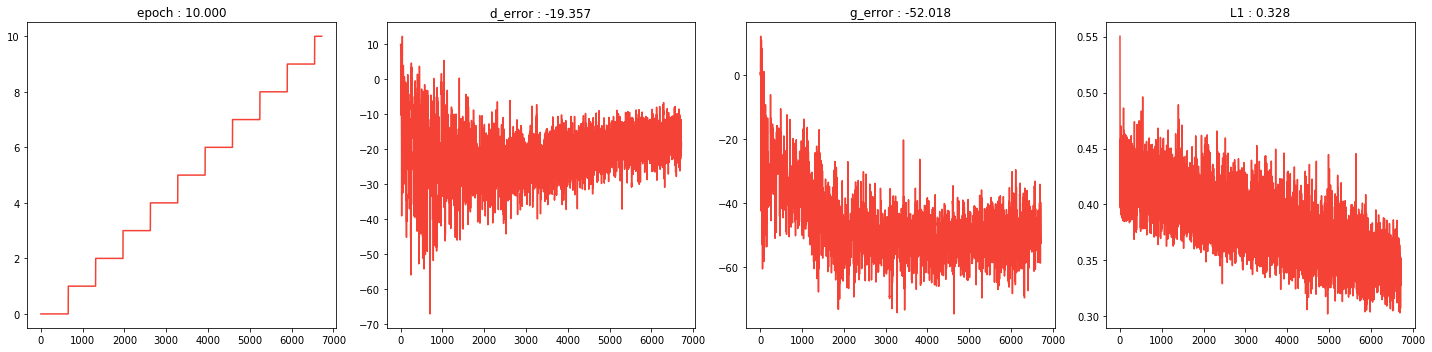

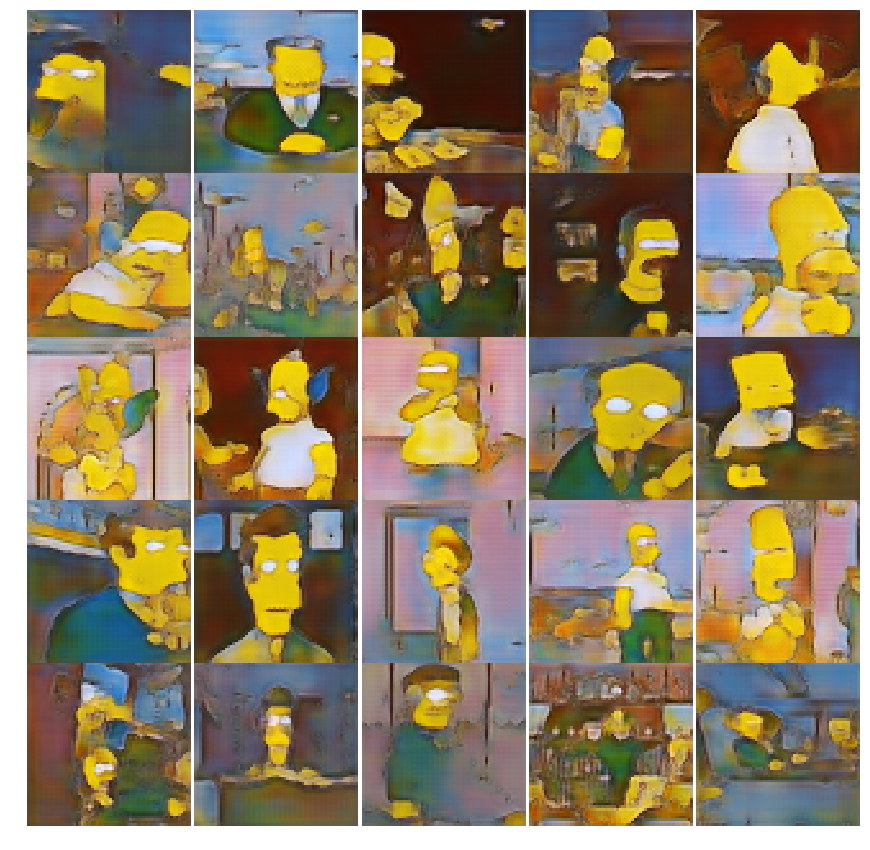

In [ ]:
gen_steps = 1
gen_train_freq = 1
if True:
    while True:
        for n_batch, (real_data,label_batch) in enumerate(data_loader):
            # 1. Train Discriminator
            real_data = real_data.to(device) 
            label_batch = label_batch.to(device)
            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            with torch.no_grad():
                fake_data = generator(label_batch)# torch.cat([noise_tensor,random_labels],1)).detach()
            # Train D
            d_error = train_discriminator(d_optimizer, real_data,label_batch, fake_data,label_batch)

            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # 2. Train Generator
                    # Generate fake data
                    real_data,label_batch = next(iter(data_loader2))
                    real_data = real_data.to(device) 
                    label_batch = label_batch.to(device)
                    fake_data = generator(label_batch)
                    # Train G
                    g_error,l1_error = train_generator(g_optimizer,fake_data,label_batch,real_data)
                    g_error,l1_error = g_error.item(),l1_error.item()
            # Log batch error
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error, 'L1':l1_error} )
            global_step+=1
            # Display Progress every few batches
            if global_step % 10 == 0:
                test_images = fake_data.permute(0,2,3,1).data.cpu().numpy()
                dis.display(scale=False)
                i_ = 0
                plt.figure(figsize=(3*m_test, 3*m_test)) 
                plt.subplots_adjust(wspace=0, hspace=0)
                for l in range(m_test**2):
                    tile = test_images[l]
                    tile = (tile-tile.min())/(tile.max()-tile.min())
                    plt.subplot(m_test, m_test, i_+1) #.set_title(l)
                    plt.imshow(tile); plt.axis('off')
                    i_ += 1
                #if global_step % 1000 == 0:
                #    plt.savefig("Simpsons-pix2pix/Simpsons-global_step="+str(global_step)+".png")
                plt.show()
        epoch+=1
if False:
    test_images = fake_data.permute(0,2,3,1).data.cpu().numpy()
    dis.display(scale=False)
    i_ = 0
    plt.figure(figsize=(3*m_test, 3*m_test)) 
    plt.subplots_adjust(wspace=0, hspace=0)
    for l in range(m_test**2):
        tile = test_images[l]
        tile = (tile-tile.min())/(tile.max()-tile.min())
        plt.subplot(m_test, m_test, i_+1) #.set_title(l)
        plt.imshow(tile); plt.axis('off')
        i_ += 1
    #if global_step % 1000 == 0:
    #    plt.savefig("Simpsons-pix2pix/Simpsons-global_step="+str(global_step)+".png")
    plt.show()

# Conclusion

The pix2pix allows us to colorize images from drawings which implies that the model is able to recognize different objects from the drawings (faces, clothes, trees) and apply the right color.